In [1]:
'''Loading required libraries'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization, MaxPool2D, AveragePooling2D
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sn


In [2]:
'''Loading the data'''

train_data = np.load("../input/usc-dsci552-section-32415d-spring-2021-ps4/ps4_trainvalid_images.npy")
train_labels = pd.read_csv("../input/usc-dsci552-section-32415d-spring-2021-ps4/ps4_trainvalid_labels.csv")
train_labels.set_index('Id', inplace=True)

In [3]:
train_data.shape

(13260, 64, 64, 1)

In [4]:
'''Normalizing the input data
Changing pixel values in the range [0-255] to [0-1]'''

train_data = train_data/255.0

In [5]:
'''Identifying the classes and number of samples per class'''

train_labels['Label'].value_counts()

0    10506
1     2372
2      382
Name: Label, dtype: int64

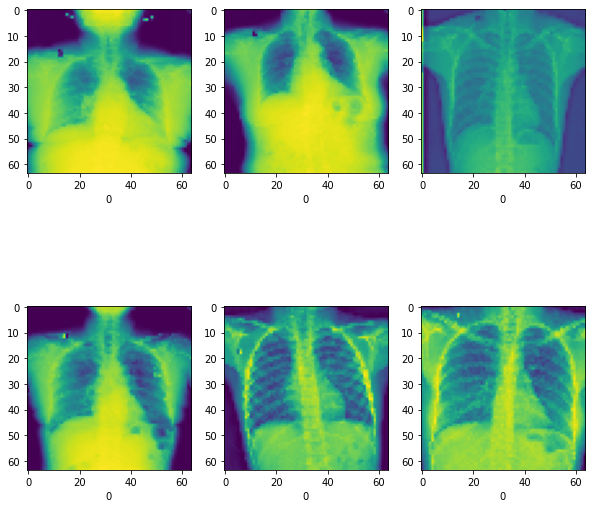

In [6]:
'''Visualizing input data'''

plt.figure(figsize=(10,10))

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(train_data[i][:,:,0])
  plt.xlabel(train_labels['Label'][i])
plt.show()

In [7]:
'''Stratified sampling of training data'''

from sklearn.model_selection import StratifiedKFold
X = train_data
Y = train_labels['Label']
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X,Y)
foldNum=0

for trainval_index, test_index in skf.split(X, Y):
    X_trainval, X_test = X[trainval_index], X[test_index]
    Y_trainval, Y_test = Y[trainval_index], Y[test_index]

In [8]:
print('Training set dimensions: ',X_trainval.shape, Y_trainval.shape)
print('Test set dimensions: ',X_test.shape, Y_test.shape)

Training set dimensions:  (10608, 64, 64, 1) (10608,)
Test set dimensions:  (2652, 64, 64, 1) (2652,)


In [9]:
Y_trainval.value_counts(), Y_test.value_counts()

(0    8405
 1    1898
 2     305
 Name: Label, dtype: int64,
 0    2101
 1     474
 2      77
 Name: Label, dtype: int64)

In [10]:
'''Splitting trainval into train and validation sets'''

from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X_trainval, Y_trainval, test_size=0.25, random_state=12)

In [11]:
print('Training set dimensions: ',train_x.shape, train_y.shape)
print('Validation set dimensions: ',val_x.shape, val_y.shape)

Training set dimensions:  (7956, 64, 64, 1) (7956,)
Validation set dimensions:  (2652, 64, 64, 1) (2652,)


# Since data is unequally represented by all samples (highly imbalanced), we perform data augmentation to increase the number of training images so as to remove class imbalance.

In [12]:
'''Performing data augmentation on trainval set'''

dataAug = ImageDataGenerator(
    
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=20, # rotate images by 20 degrees
    width_shift_range=0.2, # shift the image along the width
    height_shift_range=0.2, # shift the image along the height
    brightness_range=[0.1,1], # change the brightness on a scale of 0.1 to 1
    shear_range=0.0,
    zoom_range=0.4,# zoom inages by a scale of 0.4
    horizontal_flip=False
)

dataAug.fit(train_x)

In [13]:
'''Plot ROC AUC for all models using validation set'''

'''Referred from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html'''


from sklearn.metrics import roc_curve,roc_auc_score,auc 
from sklearn import preprocessing
from itertools import cycle


'''Function for plotting ROC curve'''

def plotmetrics(model):
    y_pred = model.predict(val_x)
    
    macro_roc_auc_ovo = roc_auc_score(val_y, y_pred, multi_class="ovo", average="macro")
    weighted_roc_auc_ovo = roc_auc_score(val_y, y_pred, multi_class="ovo", average="weighted")
    macro_roc_auc_ovr = roc_auc_score(val_y, y_pred, multi_class="ovr",average="macro")
    weighted_roc_auc_ovr = roc_auc_score(val_y, y_pred, multi_class="ovr", average="weighted")
    
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

    lb = preprocessing.LabelBinarizer()
    lb.fit(val_y)
    y_test = lb.transform(val_y)

    n_classes=3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(7,7))
    colors = cycle(['blue', 'red', 'green'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [14]:
'''Plotting accuracy of train and validation data'''

def plotaccuracy(history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{modelname} - model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# **MobileNet**

In [19]:
'''Implementing MobileNet Architecture'''

'''callback to apply early stopping - avoiding model to have increasing val loss'''

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

model = models.Sequential()
model.add(Conv2D(filters=3, kernel_size=(1,1),input_shape=(64,64,1)))

model.add(tf.keras.applications.MobileNet(
    alpha=1.0, depth_multiplier=1,
    include_top=False, weights='imagenet', classes=3, classifier_activation='softmax'))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 3)         6         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, None, None, 1024)  3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                262208    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 3,491,273
Trainable params: 3,469,385
Non-trainable params: 21,888
_________________________________________________________________


In [20]:
'''Compiling MobileNet model with callback'''

EPOCHS = 20
BATCH_SIZE = 64

optimizer = Adam(lr=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(dataAug.flow(train_x,train_y, batch_size = BATCH_SIZE) ,validation_data = dataAug.flow(val_x, val_y),epochs=EPOCHS, callbacks = [callback])

Epoch 1/20
125/125 [==============================] - 13s 82ms/step - loss: 1.1301 - accuracy: 0.7461 - val_loss: 1.1594 - val_accuracy: 0.7926
Epoch 2/20
125/125 [==============================] - 9s 72ms/step - loss: 0.3992 - accuracy: 0.8604 - val_loss: 0.4729 - val_accuracy: 0.8676
Epoch 3/20
125/125 [==============================] - 9s 72ms/step - loss: 0.3556 - accuracy: 0.8748 - val_loss: 0.5111 - val_accuracy: 0.8277
Epoch 4/20
125/125 [==============================] - 10s 78ms/step - loss: 0.3259 - accuracy: 0.8876 - val_loss: 0.4701 - val_accuracy: 0.8386
Epoch 5/20
125/125 [==============================] - 9s 73ms/step - loss: 0.3411 - accuracy: 0.8832 - val_loss: 0.4475 - val_accuracy: 0.8737
Epoch 6/20
125/125 [==============================] - 9s 70ms/step - loss: 0.3241 - accuracy: 0.8879 - val_loss: 0.3334 - val_accuracy: 0.8891
Epoch 7/20
125/125 [==============================] - 10s 77ms/step - loss: 0.3029 - accuracy: 0.8974 - val_loss: 0.3251 - val_accuracy: 0.9

One-vs-One ROC AUC scores:
0.605764 (macro),
0.642306 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.654812 (macro),
0.660627 (weighted by prevalence)


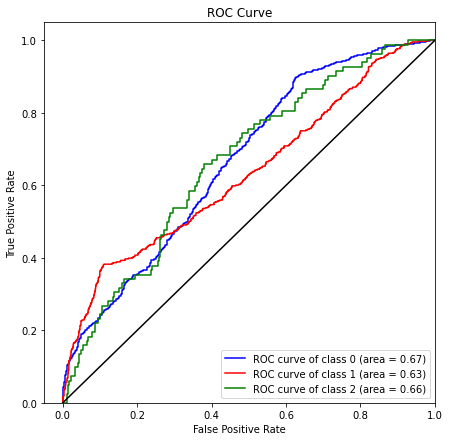

In [21]:
'''Plotting ROC Curve for MobileNet model'''

plotmetrics(model)

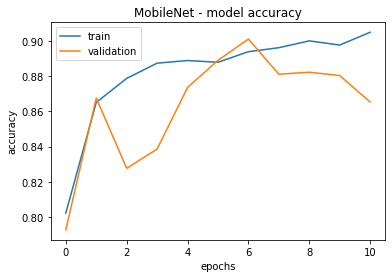

In [22]:
'''Plot train vs val accuracy for MobileNet model'''

plotaccuracy(history,'MobileNet')

# LeNet-5

In [ ]:
'''Implementing LeNet-5 Architecture'''

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
model2 = models.Sequential()
model2.add(Conv2D(20, kernel_size=(5, 5), activation='relu', input_shape=(64,64,1), padding="same"))
model2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(50, kernel_size=(5, 5), activation='relu', padding='same'))
model2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dense(3, activation='softmax'))

model2.summary()

In [ ]:
'''Compiling LeNet-5 model with callback'''

EPOCHS = 20
BATCH_SIZE = 32
optimizer = Adam(lr=0.00001)
model2.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model2.fit(dataAug.flow(train_x,train_y, batch_size=BATCH_SIZE) ,epochs = EPOCHS, validation_data = dataAug.flow(val_x, val_y), callbacks=[callback])

In [ ]:
'''Plotting ROC Curve for LeNet model'''

plotmetrics(model2)

In [ ]:
'''Plot train vs val accuracy'''

plotaccuracy(history2, 'LeNet')

# AlexNet

In [ ]:
'''Implementing AlexNet Architecture'''

model3 = models.Sequential()
model3.add(Conv2D(filters=3, kernel_size=(1,1),input_shape=(64,64,1)))

model3.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Flatten())
model3.add(Dense(4096, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4096, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(3, activation='softmax'))

model3.summary()

In [ ]:
'''Compiling AlexNet model'''

EPOCHS = 20
BATCH_SIZE = 64
optimizer = Adam(lr=0.00005)
model3.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history3 = model3.fit(dataAug.flow(train_x,train_y, batch_size=BATCH_SIZE), epochs = EPOCHS , validation_data = dataAug.flow(val_x, val_y))

In [ ]:
'''Plotting ROC Curve for AlexNet model'''

plotmetrics(model3)

In [ ]:
'''Plot train vs val accuracy'''

plotaccuracy(history3, 'AlexNet')

# VGG16 

In [ ]:
'''Implementing VGG16 Architecture'''


callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

model4 = models.Sequential()

model4.add(Conv2D(filters=3, kernel_size=(1,1),input_shape=(64,64,1)))
model4.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model4.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model4.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model4.add(Flatten())

model4.add(Dense(units=4096,activation="relu"))
model4.add(Dense(units=4096,activation="relu"))

model4.add(Dense(units=3, activation="softmax"))

model4.summary()

In [ ]:
'''Compiling VGG16 model'''

EPOCHS = 20
BATCH_SIZE = 128
optimizer = Adam(lr=0.00005)
model4.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history4 = model4.fit(dataAug.flow(train_x,train_y, batch_size=BATCH_SIZE), epochs = EPOCHS , validation_data = dataAug.flow(val_x, val_y), callbacks = [callback])

In [ ]:
'''Plotting ROC Curve for VGG16 model'''

plotmetrics(model4)

In [ ]:
'''Plot train vs val accuracy'''

plotaccuracy(history4, 'VGG16')

# RESNET152

In [ ]:
'''Implementing ResNet152 Architecture'''


callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

model5 = models.Sequential()

model5.add(Conv2D(filters=3, kernel_size=(1,1),input_shape=(64,64,1)))

model5.add(tf.keras.applications.ResNet152V2(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=3,
    classifier_activation='softmax'))

model5.add(Flatten())

model5.add(Dense(64, activation='relu'))
model5.add(Dense(3, activation='softmax'))

model5.summary()

In [ ]:
'''Compiling ResNet152 model'''

EPOCHS = 20
BATCH_SIZE = 64

optimizer = Adam(lr=0.0001)

model5.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history5 = model5.fit(dataAug.flow(train_x,train_y, batch_size = BATCH_SIZE) ,validation_data = dataAug.flow(val_x, val_y),epochs=EPOCHS, callbacks = [callback])

In [ ]:
'''Plotting ROC Curve for ResNet152 model'''

plotmetrics(model5)

In [ ]:
'''Plot train vs val accuracy'''
plotaccuracy(history5, 'ResNet152')

# Self-tried Model

In [ ]:
'''Implementing a experimental model'''

model6 = models.Sequential()

model6.add(Conv2D(3, 1, input_shape=(64,64,1)))
model6.add(Conv2D(64, 3, strides=(2,2), activation='relu'))
model6.add(MaxPooling2D(2, strides=(2,2), padding='same'))

model6.add(Conv2D(128, 3, strides=(2,2), activation='relu'))
model6.add(Conv2D(128, 3, strides=(2,2), activation='relu'))
model6.add(MaxPooling2D(2, strides=(2,2), padding='same'))

model6.add(Flatten())

model6.add(Dense(256, activation='relu'))

model6.add(Dropout(0.4))

model6.add(Dense(128, activation='relu'))

model6.add(Dense(3, activation='softmax'))

model6.summary()

In [ ]:
'''compiling the model'''

EPOCHS = 20
BATCH_SIZE = 128

optimizer = Adam(lr=0.000005)

model6.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history6 = model6.fit(dataAug.flow(train_x,train_y, batch_size = BATCH_SIZE) ,validation_data = dataAug.flow(val_x, val_y),epochs=EPOCHS)

In [ ]:
'''Plot ROC AUC'''

plotmetrics(model6)

In [ ]:
'''Plot train vs val accuracy'''

plotaccuracy(history6, 'Self-experimental')

# TESTING ALL MODELS

In [23]:
y_test = Y_test.to_numpy()
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
'''Plotting ROC AUC curves for Test Set'''

'''Referred from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html'''


from sklearn.metrics import roc_curve,roc_auc_score,auc 
from sklearn import preprocessing
from itertools import cycle

def plotrocauc(model):
    
    y_pred = model.predict(X_test)
    y_predf1 = model.predict_classes(X_test)
    
    macro_roc_auc_ovo = roc_auc_score(Y_test, y_pred, multi_class="ovo",average="macro")
    weighted_roc_auc_ovo = roc_auc_score(Y_test, y_pred, multi_class="ovo",average="weighted")
    macro_roc_auc_ovr = roc_auc_score(Y_test, y_pred, multi_class="ovr",average="macro")
    weighted_roc_auc_ovr = roc_auc_score(Y_test, y_pred, multi_class="ovr",average="weighted")
    
    
    print("One-vs-One-> {:.6f} "
          "(weighted by prevalence)"
          .format(weighted_roc_auc_ovo))
    
    print("One-vs-Rest-> {:.6f} "
          "(weighted by prevalence)"
          .format(weighted_roc_auc_ovr))
    
    print('F1 Score: ',f1_score(Y_test.to_numpy(), y_predf1, average='weighted'))

    lb = preprocessing.LabelBinarizer()
    lb.fit(Y_test)
    y_test = lb.transform(Y_test)
    
    n_classes=3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(7,7))
    
    colors = cycle(['blue', 'red', 'green'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
'''Testing LeNet-5 model'''

loss = model2.evaluate(dataAug.flow(X_test, Y_test))[0]
accuracy = model2.evaluate(dataAug.flow(X_test, Y_test))[1]

print('Loss = ',loss)
print('Accuracy = ',accuracy)

plotrocauc(model2)

83/83 [==============================] - 2s 29ms/step - loss: 0.3114 - accuracy: 0.8940
Loss =  0.31308671832084656
Accuracy =  0.8940422534942627


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


One-vs-One-> 0.650176 (weighted by prevalence)
One-vs-Rest-> 0.624829 (weighted by prevalence)
F1 Score:  0.7332392142508094


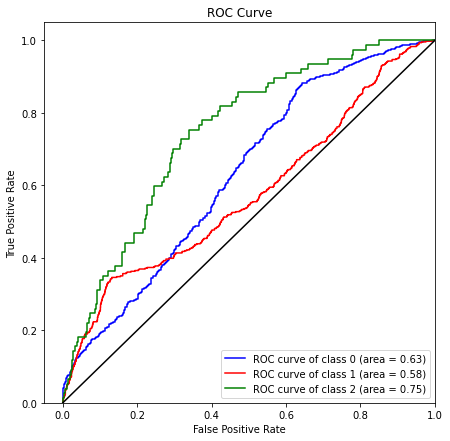

In [25]:
'''Testing MobileNet model'''

loss = model.evaluate(dataAug.flow(X_test, Y_test))[0]
accuracy = model.evaluate(dataAug.flow(X_test, Y_test))[1]

print('Loss = ',loss)
print('Accuracy = ',accuracy)

plotrocauc(model)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

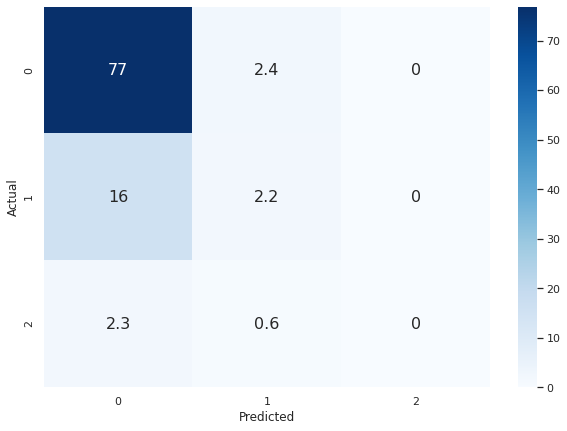

In [26]:
'''Plotting confusion matrix for MobileNet model'''

y_true1 = y_test

y_predmn = model.predict_classes(X_test)

data = confusion_matrix(y_true1, y_predmn)
data = data/np.sum(data) * 100

df_cm = pd.DataFrame(data, columns=np.unique(y_true1), index = np.unique(y_true1))

cm_sum = np.sum(data, axis=1, keepdims=True)

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (10,7))

sn.set(font_scale=1)#for label size

sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

In [ ]:
'''Testing AlexNet model'''

loss = model3.evaluate(dataAug.flow(X_test, Y_test))[0]
accuracy = model3.evaluate(dataAug.flow(X_test, Y_test))[1]

print('Loss = ',loss)
print('Accuracy = ',accuracy)

plotrocauc(model3)

In [ ]:
'''Plotting confusion matrix for AlexNet model'''

y_true = y_test

y_predalex = model3.predict_classes(X_test)

data = confusion_matrix(y_true, y_predalex)
data = data/np.sum(data) * 100

df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))

cm_sum = np.sum(data, axis=1, keepdims=True)

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (10,7))

sn.set(font_scale=1)#for label size

sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

**AlexNet misclassifies 20.9% samples while ImageNet misclassifies 21.3% samples**

In [ ]:
'''Testing VGG16 model'''

loss = model4.evaluate(dataAug.flow(X_test, Y_test))[0]
accuracy = model4.evaluate(dataAug.flow(X_test, Y_test))[1]

print('Loss = ',loss)
print('Accuracy = ',accuracy)

plotrocauc(model4)

In [ ]:
'''Testing ResNet152 model'''

loss = model5.evaluate(dataAug.flow(X_test, Y_test))[0]
accuracy = model5.evaluate(dataAug.flow(X_test, Y_test))[1]
print('Loss = ',loss)
print('Accuracy = ',accuracy)
plotrocauc(model5)

In [ ]:
'''Testing Self-experimental model'''

loss = model6.evaluate(dataAug.flow(X_test, Y_test))[0]
accuracy = model6.evaluate(dataAug.flow(X_test, Y_test))[1]

print('Loss = ',loss)
print('Accuracy = ',accuracy)

plotrocauc(model6)

# Generating Kaggle predictions

In [ ]:
'''Loading testing data'''

pred = np.load("../input/usc-dsci552-section-32415d-spring-2021-ps4/ps4_kaggle_images.npy")
#pred = pred / 255.0
prediction = model.predict_classes(pred)

In [ ]:
prediction

In [ ]:
'''Converting predictions to a dataframe -> converting to csv file'''

df = pd.DataFrame (prediction,columns=['Predicted'])
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'Id'})
df.to_csv('s1.csv',index=False)
df